# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 
import optuna
import copy
from multiprocessing import Pool, cpu_count
from datetime import datetime
import os

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms

# densenet meand and std are reported on the densenet relevant page.
densenet_mean = [0.485, 0.456, 0.406]
densenet_std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([transforms.RandomRotation(15),
                                       transforms.RandomHorizontalFlip(p=0.3),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomCrop(32, padding = 5),
                                       transforms.ToTensor(),
                                       transforms.Normalize(densenet_mean, densenet_std)])  # this is to use transfer learning with densenet

val_test_transforms = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize(densenet_mean,
                                                               densenet_std)])  # this is to use transfer learning with densenet

# Create training set and define training dataloader
train_data = torchvision.datasets.CIFAR10(root='./CIFAR10', train=True,
                                          download=True)  # transform later because we will not augment the data for the validation set

# we wrap the train/validation loaders into a function because we may want to consider having batch_size as hyperparameter (so it is easier to have our dataLoaders 
# defined. We access external variables as global, since they are project specific and we decide not to change those.

def get_train_val_loaders(batch_size = 64 , train_split = 0.85):
    # we assume a 90/10 split between training and validation test

    data_length =  len(train_data) 
    train_size = int(train_split *  data_length )
    validation_size = data_length - train_size # the remaining data

    train_indices , validation_indices = random_split(range(data_length), [train_size, validation_size])

    def subset_from_train_with_indeces_and_transform(indeces , transform):
        a_subset = Subset(train_data, indeces)
        a_subset.dataset.transform = transform
        return a_subset
    
    train_subset = subset_from_train_with_indeces_and_transform(train_indices, train_transforms)
    validation_subset = subset_from_train_with_indeces_and_transform(validation_indices, val_test_transforms)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_subset, batch_size=batch_size, shuffle=False)

    return train_loader, validation_loader


# Create test set and define test dataloader
test_data = torchvision.datasets.CIFAR10(root='./CIFAR10', train=False, download=True, transform=val_test_transforms)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False) # for the testing we do not care about batch size


# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [ ]:
# original code This works, but the images are not denormalized, as it should be. In my case I had to normalize it for densenet. 
# So I had to define a denormalize function.
# def show5(img_loader):
#     dataiter = iter(img_loader)
    
#     batch = next(dataiter)
#     labels = batch[1][0:5]
#     images = batch[0][0:5]
#     for i in range(5):
#         print(classes[labels[i]])

        
#         image = images[i].numpy()
#         plt.imshow(image.T)
#         plt.show()

cat


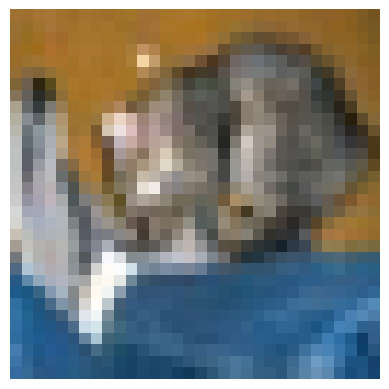

ship


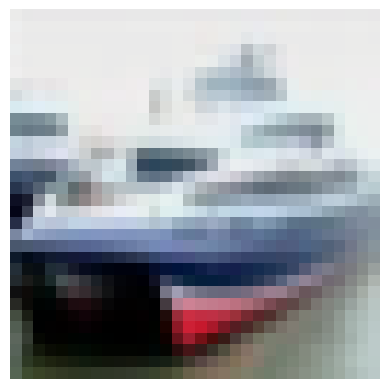

ship


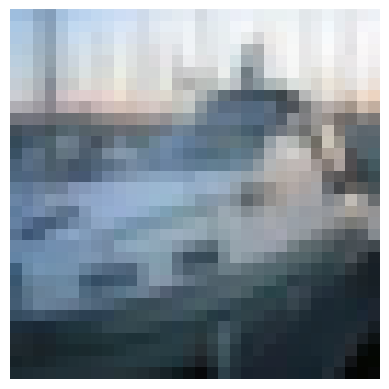

plane


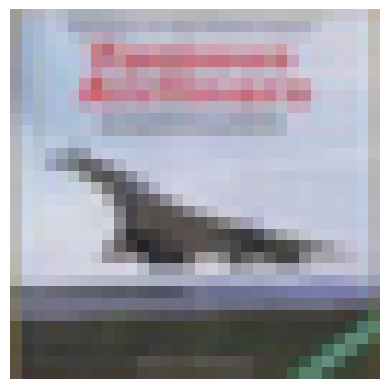

frog


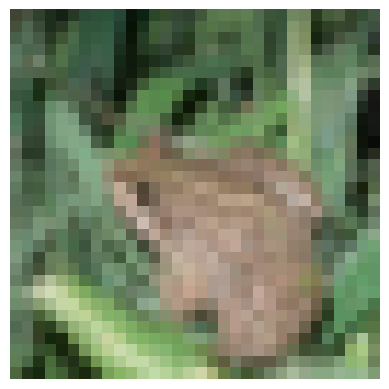

In [3]:
# improved version (denormalize and then permute indeces)
def denormalize(mean,std):

    # inverse formulas from x^ = (x - m)/s -> s*x^ + m = x -> 1/(1/s) * [ x^ - ( -m/s)]
    # so we get the inverse formulas for mean and std
    
    inverse_mean = [-m/s for m,s in zip(mean,std)]
    inverse_std = [1/s for s in std]
    return transforms.Normalize(mean=inverse_mean, std=inverse_std)


def show5(img_loader ):
    dataiter = iter(img_loader)
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    densenet_denorm = denormalize(densenet_mean, densenet_std)

    for i in range(5):
        print(classes[labels[i]])

        image = densenet_denorm(images[i])  # Denormalize the image
        image = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C)

        plt.imshow(image)
        plt.axis('off')  # Hide the axes for better visualization
        plt.show()

show5(test_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

I am going to use *transfer learning* with densenet in order to build a classifier for CIFAR10. So I need to freeze the network's weights, for the features and to define a relevant classifier (to be trained) to classify the images.

In [4]:
## YOUR CODE HERE ##
# load densenet
from torchvision import models
from torchvision.models.densenet import DenseNet161_Weights

model = models.densenet161(weights=DenseNet161_Weights.DEFAULT)

# then fix the weights for the features selection
for param in model.features.parameters():
    param.requires_grad = False # do not train the features part of the network

In [5]:
# now create a suitable classifier for my needs (number of classes are 10)
n_classes = len(classes)

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # 2208 features: this is the default for DenseNet161
        self.lin1 = nn.Linear(in_features=2208, out_features = n_classes, bias=True)
        self.logSoft = nn.LogSoftmax(dim=1)

    def forward(self,x):
        x = self.lin1(x)
        x = self.logSoft(x)
        return x 

# define the complete model
model.classifier = Classifier()

In [6]:
def create_model(freeze_internal_weights = True):
    model = models.densenet161(weights=DenseNet161_Weights.DEFAULT)

    # then fix the weights for the features selection
    
    for param in model.features.parameters():
        param.requires_grad =  not freeze_internal_weights # 

    model.classifier = Classifier()
    return model

In [7]:
# try densenet on an image
sample_batch = next(iter(test_loader))

images, labels = sample_batch

# have to put the NN into evaluation, otherwise it won't work with only one image
model.eval()
model(images[0].unsqueeze(0))

tensor([[-3.2264, -2.6403, -2.4370, -2.9478, -1.7751, -2.0801, -2.8111, -1.8382,
         -1.9401, -2.3887]], grad_fn=<LogSoftmaxBackward0>)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
#Negative Log-Likelihood (for a classifier)
criterion = nn.NLLLoss()

# use Adam as default optimizer (lr will be optimized later)
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.01)

# the model has been already instantiated and in any case I am wrapping everything inside an objective function to fine-tune the hyperparameter 
# with optuna - https://optuna.org/

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
## YOUR CODE HERE ##
# this function defines one epoch across the whole training data set, for the model.
# Hyperparameters considered are: learning rate, and batch size

def get_accuracy_on_samples(model_output, labels):
    with torch.no_grad():
        return (torch.max(model_output) == labels).sum()

def train_for_one_epoch_with_these_hyperparams(model, batch_size, learning_rate, weight_decay = 1e-5, 
                                               criterion = nn.NLLLoss() , 
                                               device = 'mps' ):
    # returns the trained model (after one epoch) and the average training and validation loss
    
    optimizer = optim.Adam(model.classifier.parameters(), lr = learning_rate)
    running_train_loss = 0.0

    train_loader, val_loader = get_train_val_loaders(batch_size=batch_size)

    model.to(device)
    model.train()

    num_training_samples = len(train_loader.dataset)
    num_val_samples = len(val_loader.dataset)
    for images, labels in tqdm(train_loader):

        # load to device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad() # put the gradient to zero

        # forward pass
        output = model(images)

        # compute the loss
        current_loss = criterion(output, labels)

        # compute backward pass
        current_loss.backward()

        # compute an optimization step
        optimizer.step()

        running_train_loss += current_loss.item()

    # compute the averate training loss per sample, as requested
    # common is also average loss per batch, but batches may have different sizes
    average_training_loss = running_train_loss / num_training_samples


    model.eval()
    running_val_loss = 0.0
    
    number_correctly_predicted = 0
    
    with torch.no_grad():
        for images_val, labels_val in val_loader:
    
            images_val , labels_val = images_val.to(device), labels_val.to(device)

            # forward pass
            predicted = model(images_val)

            # validation loss
            val_loss = criterion(predicted, labels_val)

            # accumulated loss
            running_val_loss += val_loss.item()

            # correctly predicted items
            number_correctly_predicted += (torch.argmax(predicted, dim=1) == labels_val).sum().item()
            
    
    average_val_loss = running_val_loss / num_val_samples
    val_accuracy = number_correctly_predicted / num_val_samples * 100.0
    
    return model, average_training_loss, average_val_loss, val_accuracy

Plot the training loss (and validation loss/accuracy, if recorded).

In [10]:
def train_network_for_CIFAR10(model, batch_size, lr, weight_decay,  
                              max_epochs = 500, patience = 10, 
                              criterion = nn.NLLLoss(), device = 'mps',
                              model_name = 'model', 
                              checkpoint_dir ='checkpoints/'):
    
    best_model_state = None # used to store the best model with early stopping, if needed
    average_training_loss_hist, average_val_loss_hist, val_accuracy_hist = [], [], []
    best_val_acc = 0.0
    patience_count, epoch = 0, 0
    epochs = []
    best_epoch = 0

    print(f'batch size: {batch_size}; lr: {lr}; weight decay:{weight_decay}')
    
    while patience_count < patience and epoch < max_epochs:
        
        model, av_tr_loss, av_val_loss, val_acc = train_for_one_epoch_with_these_hyperparams(model, 
                                                                                             batch_size, 
                                                                                             lr, 
                                                                                             weight_decay = weight_decay)

        average_training_loss_hist.append(av_tr_loss)
        average_val_loss_hist.append(av_val_loss)
        val_accuracy_hist.append(val_acc)
        print(f"Epoch: {epoch}")
        epochs.append(epoch)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_count = 0 # restart counting: we have a better solution
            print(f'New best accuracy: {val_acc}')
            best_model_state = copy.deepcopy(model.state_dict()) 
            best_epoch = epoch

            # Save the best model with a dynamic file name
            timestamp = datetime.now().strftime('%H-%M-%S-%f')
            filename = f'{timestamp}_bs_{batch_size}_lr{lr:.3f}_wd{weight_decay:3f}Perf{val_acc:.2f}.pth'
            checkpoint_path = os.path.join(checkpoint_dir, filename)
            torch.save(model.state_dict(), checkpoint_path)
        

        else:
            patience_count += 1

        epoch += 1 # increase epochs
        
    model.load_state_dict(best_model_state)

    histories = {}
    histories['training'] = average_training_loss_hist
    histories['validation'] = average_val_loss_hist
    histories['accuracy']= val_accuracy_hist
    histories['epochs'] = epochs # just for convenience to create plots 
    
    return model, histories
        

In [11]:
# define the objective function for optuna
def objective(trial:optuna.trial):
    
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256, 512, 1024, 2048])
    learning_rate = trial.suggest_float("learning_rate",  1e-6, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)

    model = create_model()
    model, histories = train_network_for_CIFAR10(model, 
                                                 batch_size = batch_size, 
                                                 lr = learning_rate, 
                                                 weight_decay= weight_decay, 
                                                 patience = 8, max_epochs = 300)

    best_accuracy = np.max(np.array(histories['accuracy']))

    trial.set_user_attr("model", model) 
    trial.set_user_attr("histories", histories)
    return best_accuracy

In [13]:
# set up the hyperparameters optimization with optuna
# study = optuna.create_study(direction='maximize')
num_trials = 15
# study.optimize(objective, n_trials=num_trials)

# num_processes = cpu_count()

study = optuna.create_study(direction='maximize')
study.optimize( objective, n_trials = 1 )


[I 2024-08-04 17:14:57,748] A new study created in memory with name: no-name-38eda002-44ef-4ac8-8e34-4d68fd6463a9


batch size: 32; lr: 1.4742299733972525e-06; weight decay:1.939849415167894e-06


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [01:00<00:00, 21.92it/s]


Epoch: 0
New best accuracy: 11.013333333333334


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:55<00:00, 23.89it/s]


Epoch: 1
New best accuracy: 12.6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.52it/s]


Epoch: 2
New best accuracy: 14.946666666666667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:57<00:00, 23.08it/s]


Epoch: 3
New best accuracy: 15.413333333333334


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.39it/s]


Epoch: 4
New best accuracy: 17.64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.60it/s]


Epoch: 5
New best accuracy: 18.44


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.62it/s]


Epoch: 6
New best accuracy: 20.666666666666668


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.54it/s]


Epoch: 7
New best accuracy: 22.386666666666667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.61it/s]


Epoch: 8
New best accuracy: 23.013333333333332


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.34it/s]


Epoch: 9
New best accuracy: 24.53333333333333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.37it/s]


Epoch: 10
New best accuracy: 25.186666666666667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.51it/s]


Epoch: 11
New best accuracy: 27.133333333333333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:57<00:00, 23.18it/s]


Epoch: 12
New best accuracy: 27.89333333333333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:57<00:00, 23.27it/s]


Epoch: 13
New best accuracy: 29.773333333333333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.44it/s]


Epoch: 14
New best accuracy: 30.533333333333335


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.37it/s]


Epoch: 15
New best accuracy: 32.440000000000005


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.37it/s]


Epoch: 16
New best accuracy: 32.800000000000004


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:57<00:00, 23.24it/s]


Epoch: 17
New best accuracy: 34.81333333333333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.45it/s]


Epoch: 18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.66it/s]


Epoch: 19
New best accuracy: 35.29333333333333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.64it/s]


Epoch: 20
New best accuracy: 36.093333333333334


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.62it/s]


Epoch: 21


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.70it/s]


Epoch: 22
New best accuracy: 36.89333333333333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.55it/s]


Epoch: 23
New best accuracy: 38.78666666666667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.51it/s]


Epoch: 24
New best accuracy: 39.093333333333334


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.61it/s]


Epoch: 25
New best accuracy: 39.54666666666667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.42it/s]


Epoch: 26
New best accuracy: 40.13333333333333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.67it/s]


Epoch: 27
New best accuracy: 40.986666666666665


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.47it/s]


Epoch: 28
New best accuracy: 41.48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:55<00:00, 23.74it/s]


Epoch: 29


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.50it/s]


Epoch: 30


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.70it/s]


Epoch: 31
New best accuracy: 41.6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.49it/s]


Epoch: 32


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.57it/s]


Epoch: 33
New best accuracy: 42.22666666666667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.33it/s]


Epoch: 34


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.60it/s]


Epoch: 35
New best accuracy: 42.50666666666667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:57<00:00, 23.26it/s]


Epoch: 36
New best accuracy: 43.45333333333333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.43it/s]


Epoch: 37
New best accuracy: 43.46666666666666


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.39it/s]


Epoch: 38
New best accuracy: 44.25333333333333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.34it/s]


Epoch: 39


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.55it/s]


Epoch: 40


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.54it/s]


Epoch: 41


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.41it/s]


Epoch: 42
New best accuracy: 44.74666666666667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:57<00:00, 23.06it/s]


Epoch: 43
New best accuracy: 45.04


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.63it/s]


Epoch: 44
New best accuracy: 46.06666666666667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.56it/s]


Epoch: 45
New best accuracy: 46.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:55<00:00, 23.78it/s]


Epoch: 46
New best accuracy: 46.68


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.59it/s]


Epoch: 47


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.65it/s]


Epoch: 48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.72it/s]


Epoch: 49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.70it/s]


Epoch: 50
New best accuracy: 48.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.34it/s]


Epoch: 51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.50it/s]


Epoch: 52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.60it/s]


Epoch: 53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.57it/s]


Epoch: 54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.58it/s]


Epoch: 55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.60it/s]


Epoch: 56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.52it/s]


Epoch: 57


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:56<00:00, 23.59it/s]
[I 2024-08-04 18:18:32,297] Trial 0 finished with value: 48.0 and parameters: {'batch_size': 32, 'learning_rate': 1.4742299733972525e-06, 'weight_decay': 1.939849415167894e-06}. Best is trial 0 with value: 48.0.


Epoch: 58


In [37]:
histories = study.best_trial.user_attrs['histories']

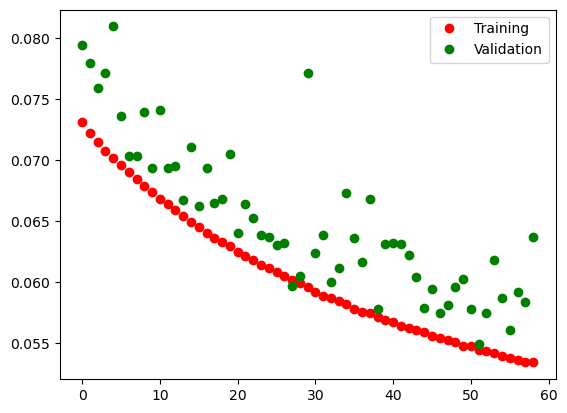

In [47]:
%matplotlib inline 

fig, ax = plt.subplots()

ax.plot(histories['epochs'], histories['training'] ,'ro' ,label ='Training Loss')

ax.plot(histories['epochs'], histories['validation'] ,'go', label='Validation Loss')
leg = ax.legend()
plt.show()


In [48]:
# I have optimized more extensively and have recorded the best model. Now I am loading it

# keep training the model (unfreezing all weights) to improve performance
# best_model is 19-09-07-742621_bs_2048_lr0.001_wd0.000001Perf61.28.pth
best_model_dict = torch.load('checkpoints/23-33-41-628273_bs_1024_lr0.000_wd0.000010Perf62.32.pth', map_location='mps')
best_model =create_model()
best_model.load_state_dict(best_model_dict)

<All keys matched successfully>

Unfreezing the inner weights does not seem to improve performance. I have found that progressively enlarging the image size of the input is pivotal in improving the network's performance ref: Deep Learning for Coders with Fastai and PyTorch: AI Applications Without a PhD, Howard et al.

I will explore this further, but I would like to submit the project as is, for now. Without these tricks it is difficult to achieve 70+%.

In [49]:
# initial code to experiment with in the future
# Function to get train transforms with resizing
def get_train_transforms(image_size):
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(),
        transforms.RandomCrop(image_size, padding=5),
        transforms.ToTensor(),
        transforms.Normalize(densenet_mean, densenet_std)
    ])

# Function to get validation/test transforms with resizing
def get_val_test_transforms(image_size):
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(densenet_mean, densenet_std)
    ])


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [58]:
best_model.cpu()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [63]:
## YOUR CODE HERE ##
device = 'mps'
best_model.to(device)
best_model.eval()
running_val_loss = 0.0
   
number_correctly_predicted = 0
    
with torch.no_grad():
    for images_val, labels_val in test_loader:
    
        images_val , labels_val = images_val.to(device), labels_val.to(device)

            # forward pass
        predicted = best_model(images_val)

            # validation loss
        val_loss = criterion(predicted, labels_val)

            # accumulated loss
        running_val_loss += val_loss.item()

            # correctly predicted items
        number_correctly_predicted += (torch.argmax(predicted, dim=1) == labels_val).sum().item()

print(f'Validation Loss: {running_val_loss / len(test_loader)}')
print(f'Accuracy: {number_correctly_predicted / len(test_loader.dataset)}')

Validation Loss: 1.2856756593011747
Accuracy: 0.5712


## Saving your model
Using `torch.save`, save your model for future loading.

In [64]:
# the saving has been performed inside the optimization
# Save the best model with a dynamic file name
# timestamp = datetime.now().strftime('%H-%M-%S-%f')
# filename = f'{timestamp}_bs_{batch_size}_lr{lr:.3f}_wd{weight_decay:3f}Perf{val_acc:.2f}.pth'
# checkpoint_path = os.path.join(checkpoint_dir, filename)
# torch.save(model.state_dict(), checkpoint_path)

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

70% seems a challenging benchmark to beat, without enlarging the data and adopting complex architecture. Given teh current state of the model, I would recommend to buy an object detection solution. In reality, I would keep experimenting with progressively enlarging the image size. I noticed that unfreezing all the parameters does not significantly increase the model performance, but data augmentation would. Would I exceed 70%? I will try in the future and check: for now the recommendation is to buy.
